In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from sasha_tools import *
import matplotlib.pyplot as plt

plt.style.use('bmh')

In [3]:
df = pd.read_csv('sample.csv', sep = ';')

In [4]:
#Make date and time features
df['date'] = pd.to_datetime(df['APPDATE'].apply(lambda x : str(x)[:10]), format = '%d.%m.%Y')
df['hour'] = pd.to_datetime(df['APPDATE'].apply(lambda x : str(x)[11:]), format = '%H:%M:%S', errors = 'coerce').dt.hour
df['date_full'] = df['date'].astype(str) + ' ' + pd.to_datetime(df['APPDATE'].apply(lambda x : str(x)[11:]), format = '%H:%M:%S', errors = 'coerce').astype(str).apply(lambda x : str(x)[-8:])
df['day_of_week'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.year * 10 + df['date'].dt.quarter
df['month'] = df['date'].dt.year * 10 + df['date'].dt.month


#Split dataset on train and test. Model wouldn't count yearly+ seasons, as we have only a year of data. 
# Also assume, that model is calibrated, so we have to worry only about ranking power of our model on a test data, not a mean fit
#Take a last quarter for a backtesting

train_indx = (df['date'] <= '2022-03-31')
'Fraction of train is: ', round(train_indx.mean(), 3)

('Fraction of train is: ', 0.803)

In [5]:
import re
from nltk.tokenize import WordPunctTokenizer
import pymorphy2
from collections import Counter


#We wouldn't split data for train and test here as it is unsupervised learning feature

pos_indx = df['PRODUCTTYPE'].isin(df['PRODUCTTYPE'].value_counts().index[0:1]) & ~df['MODEL'].isin(['EMPTY', '0', 'NaN']) & ~df['MODEL'].isna() #Only applications with text description

tokenizer = WordPunctTokenizer()
data_tok = [tokenizer.tokenize(text.lower()) for text in df.loc[pos_indx, 'MODEL'].values]
analyzer = pymorphy2.MorphAnalyzer()
word_count = Counter([analyzer.parse(word)[0].normal_form for text in data_tok for word in list(set(text)) if word.isalpha()]) #Count number of occurencies of all words in normal form



In [6]:
df.loc[pos_indx, 'MODEL_parse'] = df.loc[pos_indx, 'MODEL'].apply(lambda text : list(set([analyzer.parse(word)[0].normal_form for word in tokenizer.tokenize(str(text).lower()) if word.isalpha()])))

# Aquire all unique normalized words from a text description

In [7]:
import gensim.downloader as api


model = api.load("glove-twitter-100") #download pretrained word2vec model

In [8]:
#sec2vec function with a weighted (by a number of occurencies) mean of word vectors
def weighted_average_embedding(seq, seq2vec, word_count):
    words = [word for word in seq if word in seq2vec]
    embeddings = [seq2vec[word] for word in words]
    weights = [word_count[word] for word in words]
    return np.average(embeddings, weights = weights, axis = 0) if len(embeddings) > 0 else np.zeros(100)

In [9]:
df.loc[pos_indx, 'MODEL_emb'] = df.loc[pos_indx, 'MODEL_parse'].apply(lambda seq : weighted_average_embedding(seq, model, word_count))

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
pca = PCA(2)
scaler = StandardScaler()
# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance

seq_vectors = np.array([list(emb) for emb in df.loc[~df['MODEL_emb'].isna(), 'MODEL_emb'].values])
seq_sentences = df.loc[~df['MODEL_emb'].isna(), 'MODEL_parse'].values

pipeline = make_pipeline(pca, scaler)
seq_vectors_pca = pipeline.fit_transform(seq_vectors)


In [17]:
import bokeh.models as bm
import bokeh.plotting as pl
from bokeh.io import output_notebook


output_notebook()


def draw_vectors(
    x, y, radius=10, alpha=0.25, color="blue", width=600, height=400, show=True, **kwargs
):
    """draws an interactive plot for data points with auxilirary info on hover"""
    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({"x": x, "y": y, "color": color, **kwargs})

    fig = pl.figure(active_scroll="wheel_zoom", width=width, height=height)
    fig.scatter("x", "y", size=radius, color="color", alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig


Loading BokehJS ...

In [18]:
from sklearn.cluster import DBSCAN, KMeans
kmeans = KMeans(3)
labels = kmeans.fit_predict(np.asarray(seq_vectors))

In [20]:
colors = ['red', 'blue', 'green', 'yellow', 'cyan']
draw_vectors(
    seq_vectors_pca[::150, 0],
    seq_vectors_pca[::150, 1],
    color=[colors[l] for l in labels[::150]],
    token = seq_sentences[::150],
    radius=10,
    alpha = 0.2
)
#We have aquired 3 meta categories of our POS credits: red - iphones, green - xiaomi + samsung, blue - other things (TV, smart devices, education, furniture)

figure(id='p1049', ...)

In [22]:
df.loc[~df['MODEL_emb'].isna(), 'Meta_category'] = labels

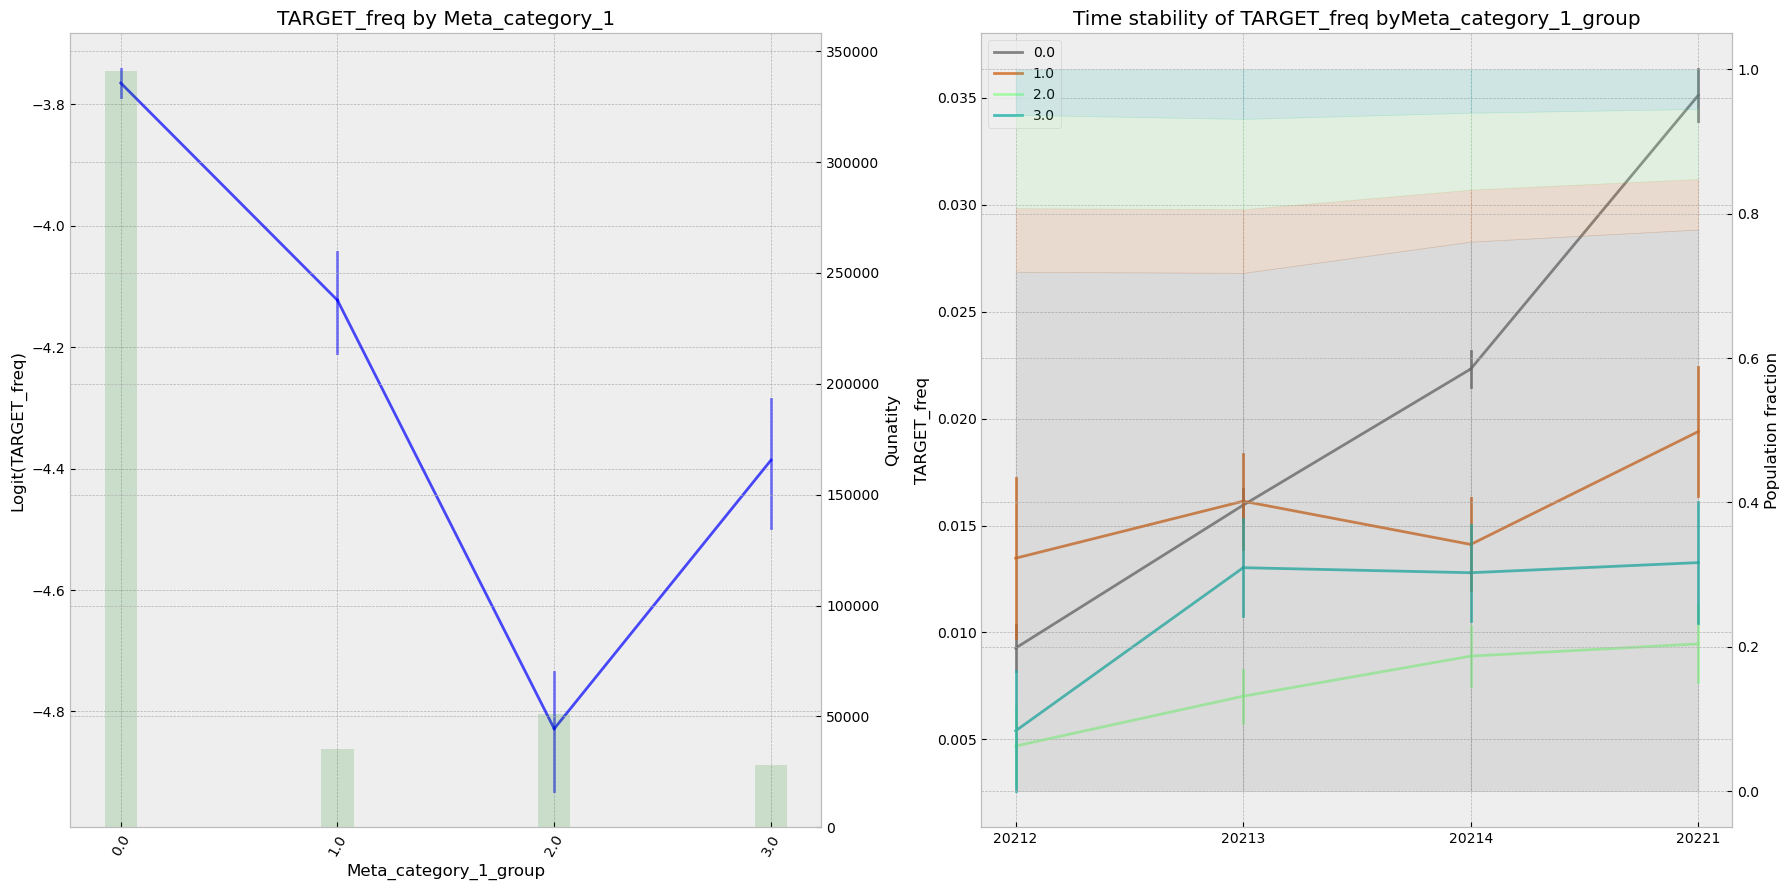

In [27]:
df['Meta_category_1'] = (df['Meta_category'] + 1).fillna(0)
df['edinici'] = 1
qwe = one_dim_analysis(df = df[train_indx],
                prop = 'Meta_category_1',
                weight = 'edinici',
                target = 'TARGET',
                time = 'quarter',
                split_group_flag = False,
                n_groups = 6,
                time_flag = True,
                bootstrap = False
                )

In [28]:
df['iphone_category'] = 1 * (df['Meta_category'] == 0)
df['xiaomi_category'] = 1 * (df['Meta_category'] == 1)
df['other_category'] = 1 * (df['Meta_category'] == 2)
df[['APPID', 'iphone_category', 'xiaomi_category', 'other_category']].to_csv('text_categories.csv', index = False)